## Block 6 chapter 3

In [1]:
"""Bayesian way"""
import arviz as az
import stan
import nest_asyncio
nest_asyncio.apply()

"""Basic ones"""
import polars as pl
from plotnine import *
import matplotlib.pyplot as plt
plt.show()  # for display figures after ggplot
# plt.rcParams['axes.grid'] = True
import numpy as np
import seaborn as sns
import pandas
import statsmodels.api as sm
from datetime import datetime

import warnings
warnings.simplefilter("ignore")

## Stanコードを書いてみる

ローカルレベルモデルの実装

$\mu_t = \mu_{t-1} + w_t, \quad w_t \sim N(0, \sigma_w^2)$ ・・・状態方程式<br>
$w_t$: 過程誤差<br>
(もしくは，$\mu_t \sim N(\mu_{t-1}, \sigma_w^2)$でも状態方程式を表せる)

$y_t = \mu_t + v_t, \quad v_t \sim N(0, \sigma_v^2)$ ・・・観測方程式<br>
$v_t$: 観測誤差<br>
(もしくは，$y_t \sim N(\mu_t, \sigma_v^2)$でも状態方程式を表せる)

ただし，$\mu_1 \sim N(\mu_0, \sigma_w^2)$．$\mu_0$は状態の初期値．

In [2]:
# data
n_sample = 100 # number of samples
y = np.zeros(n_sample)

# parameters
mu_zero = 100 # initial value of state
mu = np.zeros(n_sample)
s_w = 1000 # variance of process error (sigma_w)
s_v = 5000 # variance of observation error (sigma_v)

y.sum(), mu.sum()

(0.0, 0.0)

## Make model

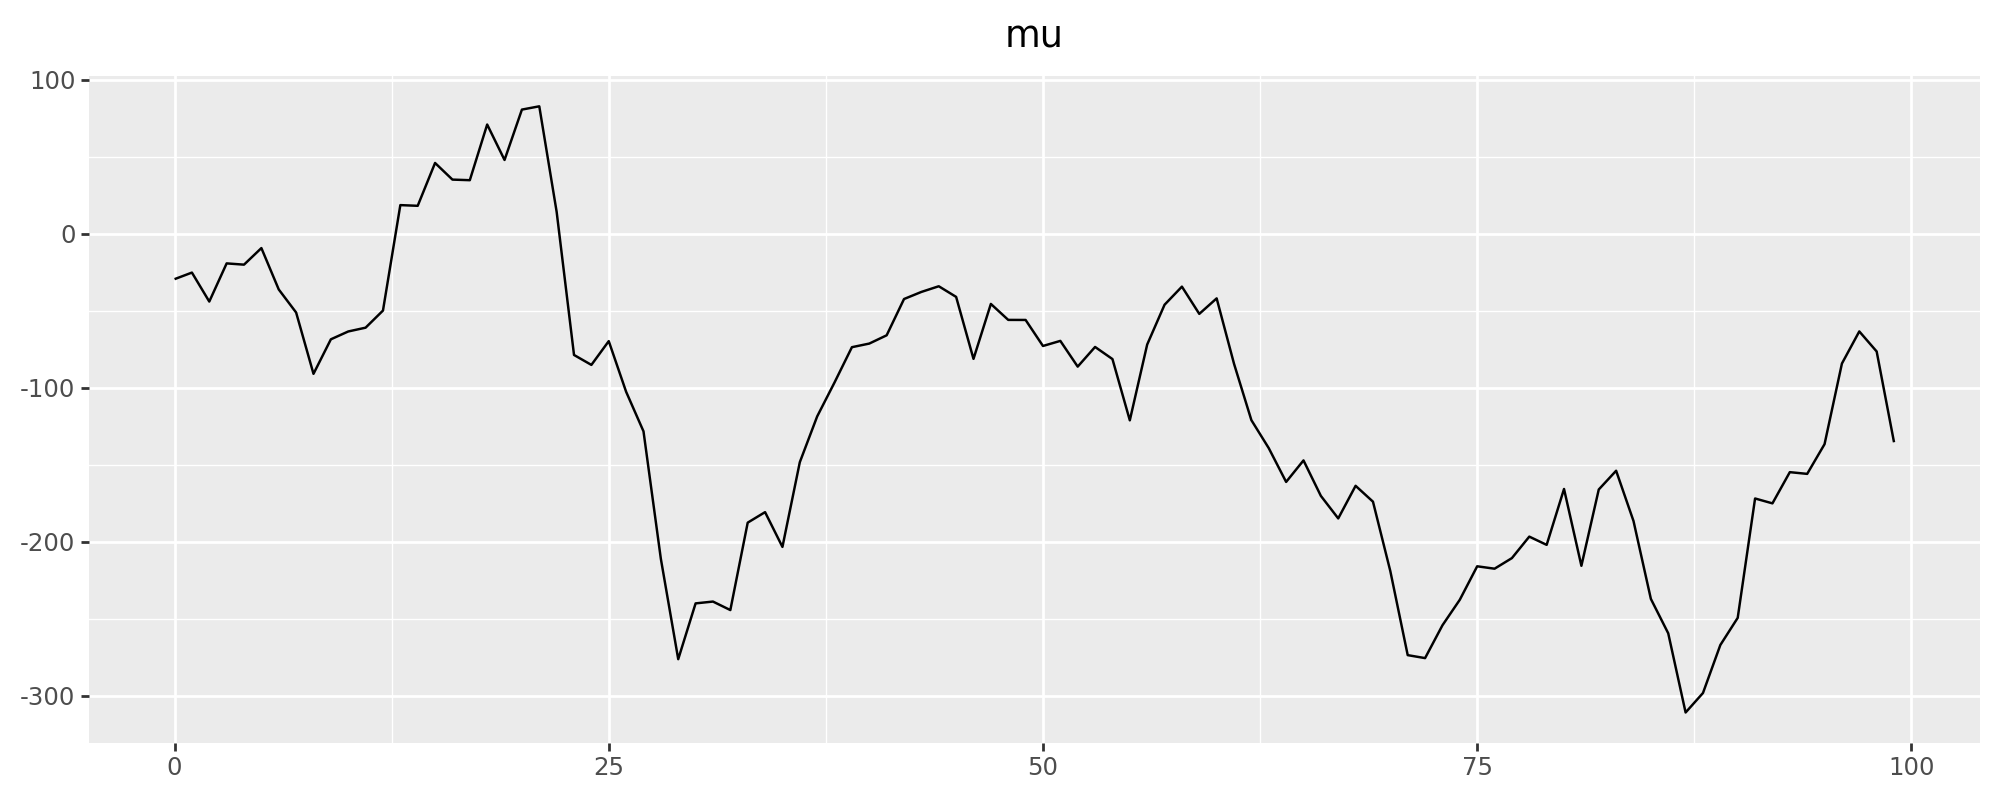

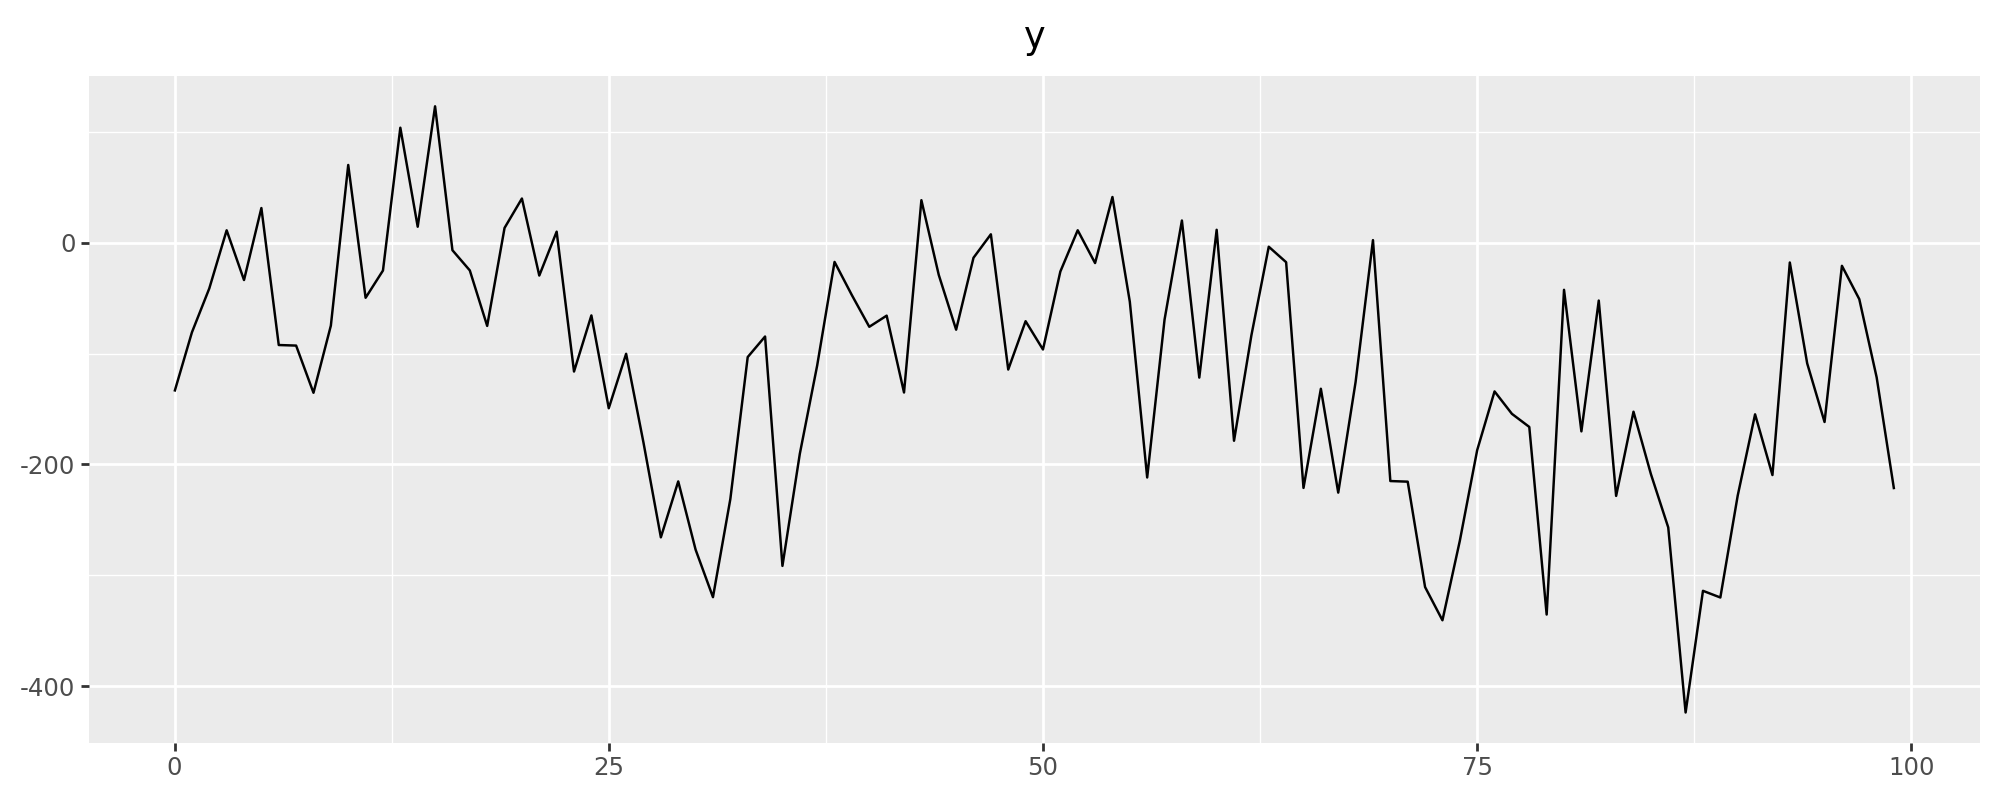

In [3]:
mu[0] = np.random.normal(loc=mu[0], scale=np.sqrt(s_w), size=1)

# equation of observation
for i in range(1, n_sample):
    mu[i] = np.random.normal(loc=mu[i-1], scale=np.sqrt(s_w), size=1)

# equation of state
for i in range(0, n_sample):
    y[i] = np.random.normal(loc=mu[i], scale=np.sqrt(s_v), size=1)
    
gg1 = (
    ggplot()
    + geom_line(aes(x=range(len(mu)), y=mu))
    # + theme(figure_size=(10, 4), axis_text_x=element_blank())
    + theme(figure_size=(10, 4))
    + labs(title="mu")
)
gg2 = (
    ggplot()
    + geom_line(aes(x=range(len(y)), y=y))
    + theme(figure_size=(10, 4))
    + labs(title="y")
)
print(gg1, end="")
print(gg2, end="")

Rとpystanのsample()の出力の形式が違うみたい

e.g.) iter (num_samples) = 5000, warmup (num_warmup) = 2500, thin (num_thin) = 5, chains (num_chains) = 4 の時

R stan だと
- Number of Draws = ((iter - warmup) / thin) * chains = 2000
- iterにwarmupが含まれてるから，実質サンプリングに使われてるのが iter - warmup で，そこからthinが適用される
- つまり，2000行の出力が返ってくる

Pystan だと
- Number of Draws = (num_samples / num_thin) * num_chains = 4000
- num_samplesにwarmupが含まれていない，5000回のサンプリングの前にwarmupをしてる．
- つまり4000行の出力が返ってくる
- R stan に合わせようとすると
  - num_samples = num_samples - num_warmup = 2500, num_warmup, num_thin, num_chainsを同じにするとなる

In [4]:
df = {"n_sample": n_sample, "y": y}
with open("6-3.stan", "r") as fstan:
    posterior = stan.build(fstan.read(), data=df, random_seed=1023)
fit = posterior.sample(num_chains=4, num_samples=2500, num_warmup=2500, num_thin=5)
result = fit.to_frame()
result = result.drop(['accept_stat__', 'stepsize__', 'treedepth__', 'n_leapfrog__', 'divergent__', 'energy__'], axis=1)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/20000)
Sampling:   0% (2/20000)
Sampling:   0% (3/20000)
Sampling:   0% (4/20000)
Sampling:   1% (103/20000)
Sampling:   2% (402/20000)
Sampling:   5% (1001/20000)
Sampling:   6% (1200/20000)
Sampling:  13% (2600/20000)
Sampling:  22% (4500/20000)
Sampling:  44% (8900/20000)
Sampling:  68% (13700/20000)
Sampling:  86% (17200/20000)
Sampling: 100% (20000/20000)
Sampling: 100% (20000/20000), done.
Messages received during sampling:
  Gradient evaluation took 0.000324 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.24 seconds.
  Adjust your expectations

In [5]:
result

parameters,lp__,mu_zero,mu.1,mu.2,mu.3,mu.4,mu.5,mu.6,mu.7,mu.8,...,mu.93,mu.94,mu.95,mu.96,mu.97,mu.98,mu.99,mu.100,s_w,s_v
draws,,,,,,,,,,,,,,,,,,,,,
0,-886.059749,-135.344132,-186.876888,-159.823918,-60.233086,-52.587485,6.633723,6.680467,-31.376765,-139.670440,...,-180.050866,-94.478703,-97.706904,-88.104716,-127.608752,-93.028287,-130.946403,-222.890481,2945.498624,4415.477056
1,-861.183372,39.929679,-48.652737,-77.878971,-78.155589,-99.943509,-48.287285,-97.080981,-118.679218,-60.390332,...,-140.021736,-151.240292,-103.152703,-96.449192,-62.620060,-88.607325,-116.142350,-123.510655,1376.707717,5336.173435
2,-850.673803,-74.927843,-79.329549,-96.369498,-86.055535,-1.390947,-48.468886,-32.338800,-61.440019,-100.793837,...,-166.246997,-155.747805,-134.553233,-77.779843,-112.802104,-111.278242,-110.457884,-114.527976,1013.109928,5073.234107
3,-896.000774,138.859868,-117.774497,-85.997760,-113.823965,-39.738949,-34.036367,-55.410258,-78.249450,-109.680086,...,-133.458794,-129.463674,-128.929791,-109.438271,-14.080520,-40.854290,-132.590431,-119.631656,3859.904797,2931.877015
4,-860.057242,-103.316680,-107.911100,-71.240364,-34.081591,-43.591320,-20.532305,-27.885529,-15.684896,-42.331828,...,-172.468330,-130.314604,-141.080412,-118.539827,-114.576711,-96.552266,-115.792914,-171.276033,1063.423867,3975.997061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-857.281056,-65.436392,-65.834220,-68.878896,6.128839,-32.978155,-53.681742,-83.774676,-97.780568,-120.542506,...,-165.021399,-115.158075,-97.216285,-71.943184,-109.370268,-75.678743,-120.746512,-91.793214,1109.585810,4329.700900
1996,-833.058583,-13.465946,-48.743402,-60.539624,-34.485146,-19.607841,-29.513334,-42.428814,-25.428406,-44.641949,...,-163.758356,-148.099529,-164.461469,-137.084768,-148.475258,-97.015546,-146.272743,-153.697644,817.215297,4910.356645
1997,-880.395165,-201.226652,-173.273592,-71.731331,-107.757804,-64.851351,-47.746852,-24.327921,-39.886097,-75.542749,...,-194.446137,-96.013484,-90.022049,-92.996997,-83.391597,-76.342235,-76.063355,-57.087150,1994.645186,4310.716230


In [6]:
mu_name = [f"mu.{i}" for i in range(1, n_sample+1)]
result_mu = result[mu_name].values
result_mu[:, 0] # 1時点のサンプリングデータ
result_mu[0, :] # 1 ~ 100時点の状態

array([-1.86876888e+02, -1.59823918e+02, -6.02330856e+01, -5.25874847e+01,
        6.63372264e+00,  6.68046742e+00, -3.13767650e+01, -1.39670440e+02,
       -1.38610878e+02, -6.53645606e+01,  3.16578805e+01, -9.38197936e+00,
        6.17374330e+01,  1.96385768e+01,  5.36810557e+01,  1.03428713e+02,
        7.67780653e+01,  3.43966251e+01,  1.02587507e+01,  2.14266056e+01,
       -4.43101792e+00,  1.79547007e-01, -3.20723700e+01, -1.45627055e+02,
       -1.18129493e+02, -1.80222726e+02, -1.81429991e+02, -1.97710354e+02,
       -2.44598457e+02, -2.69938521e+02, -2.47146150e+02, -1.95070469e+02,
       -2.11315402e+02, -1.83807564e+02, -1.37293852e+02, -1.82022677e+02,
       -1.38365850e+02, -1.04177168e+02, -8.22338691e+01, -4.85063894e+01,
       -3.67986472e+01, -1.39842721e+01, -6.66451428e+01, -3.98206383e+00,
       -1.16143206e+01, -1.13026223e+02, -2.32583115e+01, -5.67193323e+01,
       -1.18624319e+02, -6.07726821e+01, -8.58356982e+01, -3.12488164e+01,
       -1.83046191e+01, -

In [7]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_zero,-90.572,64.702,-211.409,24.926,1.471,1.071,1946.0,1856.0,1.0
mu[0],-90.802,46.539,-178.796,-4.023,1.076,0.761,1878.0,1711.0,1.0
mu[1],-73.878,39.590,-153.628,-3.694,0.898,0.651,1950.0,1786.0,1.0
mu[2],-51.306,37.811,-121.402,21.420,0.829,0.610,2086.0,1971.0,1.0
mu[3],-32.520,38.845,-104.069,42.393,0.884,0.680,1919.0,1844.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[97],-99.826,39.016,-169.375,-24.511,0.930,0.678,1742.0,1763.0,1.0
mu[98],-126.494,39.570,-196.566,-47.545,0.886,0.627,1995.0,1735.0,1.0
mu[99],-154.909,45.765,-238.813,-69.670,1.018,0.720,2027.0,1915.0,1.0
s_w,1952.724,956.269,618.921,3707.341,33.968,24.028,692.0,908.0,1.0


In [8]:
result[mu_name]

parameters,mu.1,mu.2,mu.3,mu.4,mu.5,mu.6,mu.7,mu.8,mu.9,mu.10,...,mu.91,mu.92,mu.93,mu.94,mu.95,mu.96,mu.97,mu.98,mu.99,mu.100
draws,,,,,,,,,,,,,,,,,,,,,
0,-186.876888,-159.823918,-60.233086,-52.587485,6.633723,6.680467,-31.376765,-139.670440,-138.610878,-65.364561,...,-303.075409,-201.572792,-180.050866,-94.478703,-97.706904,-88.104716,-127.608752,-93.028287,-130.946403,-222.890481
1,-48.652737,-77.878971,-78.155589,-99.943509,-48.287285,-97.080981,-118.679218,-60.390332,-73.345007,-54.235535,...,-227.348613,-175.242633,-140.021736,-151.240292,-103.152703,-96.449192,-62.620060,-88.607325,-116.142350,-123.510655
2,-79.329549,-96.369498,-86.055535,-1.390947,-48.468886,-32.338800,-61.440019,-100.793837,-102.755651,-77.364237,...,-209.738454,-158.642241,-166.246997,-155.747805,-134.553233,-77.779843,-112.802104,-111.278242,-110.457884,-114.527976
3,-117.774497,-85.997760,-113.823965,-39.738949,-34.036367,-55.410258,-78.249450,-109.680086,-61.018485,-69.940284,...,-221.999836,-174.529289,-133.458794,-129.463674,-128.929791,-109.438271,-14.080520,-40.854290,-132.590431,-119.631656
4,-107.911100,-71.240364,-34.081591,-43.591320,-20.532305,-27.885529,-15.684896,-42.331828,-38.892048,5.091796,...,-237.065732,-194.822273,-172.468330,-130.314604,-141.080412,-118.539827,-114.576711,-96.552266,-115.792914,-171.276033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-65.834220,-68.878896,6.128839,-32.978155,-53.681742,-83.774676,-97.780568,-120.542506,-95.712266,-53.842868,...,-202.257170,-188.496258,-165.021399,-115.158075,-97.216285,-71.943184,-109.370268,-75.678743,-120.746512,-91.793214
1996,-48.743402,-60.539624,-34.485146,-19.607841,-29.513334,-42.428814,-25.428406,-44.641949,-49.284140,-28.347837,...,-240.272268,-194.766633,-163.758356,-148.099529,-164.461469,-137.084768,-148.475258,-97.015546,-146.272743,-153.697644
1997,-173.273592,-71.731331,-107.757804,-64.851351,-47.746852,-24.327921,-39.886097,-75.542749,-96.032333,-111.201978,...,-235.307324,-175.366875,-194.446137,-96.013484,-90.022049,-92.996997,-83.391597,-76.342235,-76.063355,-57.087150


In [9]:
percentile = result[mu_name].apply(np.percentile, axis=0, args=([2.5, 50, 97.5],))
percentile = percentile.T
percentile.columns = ["lwr", "fit", "upr"]
percentile

,lwr,fit,upr
parameters,,,
mu.1,-184.436928,-90.528508,-3.869831
mu.2,-153.246671,-74.517461,6.295790
mu.3,-127.305904,-51.850943,25.145096
mu.4,-110.050363,-32.963459,43.982942
mu.5,-106.123801,-33.221610,45.137764
...,...,...,...
mu.96,-186.055680,-116.061011,-43.313094
mu.97,-167.672811,-92.942045,-15.894028
mu.98,-173.618078,-101.180557,-18.552818


In [25]:
percentile["y"] = y
percentile["time"] = range(1, len(percentile)+1)
(
    ggplot(data=percentile, aes(x="time"))
    + geom_point(aes(y=y), alpha=0.6, size=0.9)
    # + geom_line(aes(x=time, y=fit))
)

SyntaxError: positional argument follows keyword argument (4247426546.py, line 4)

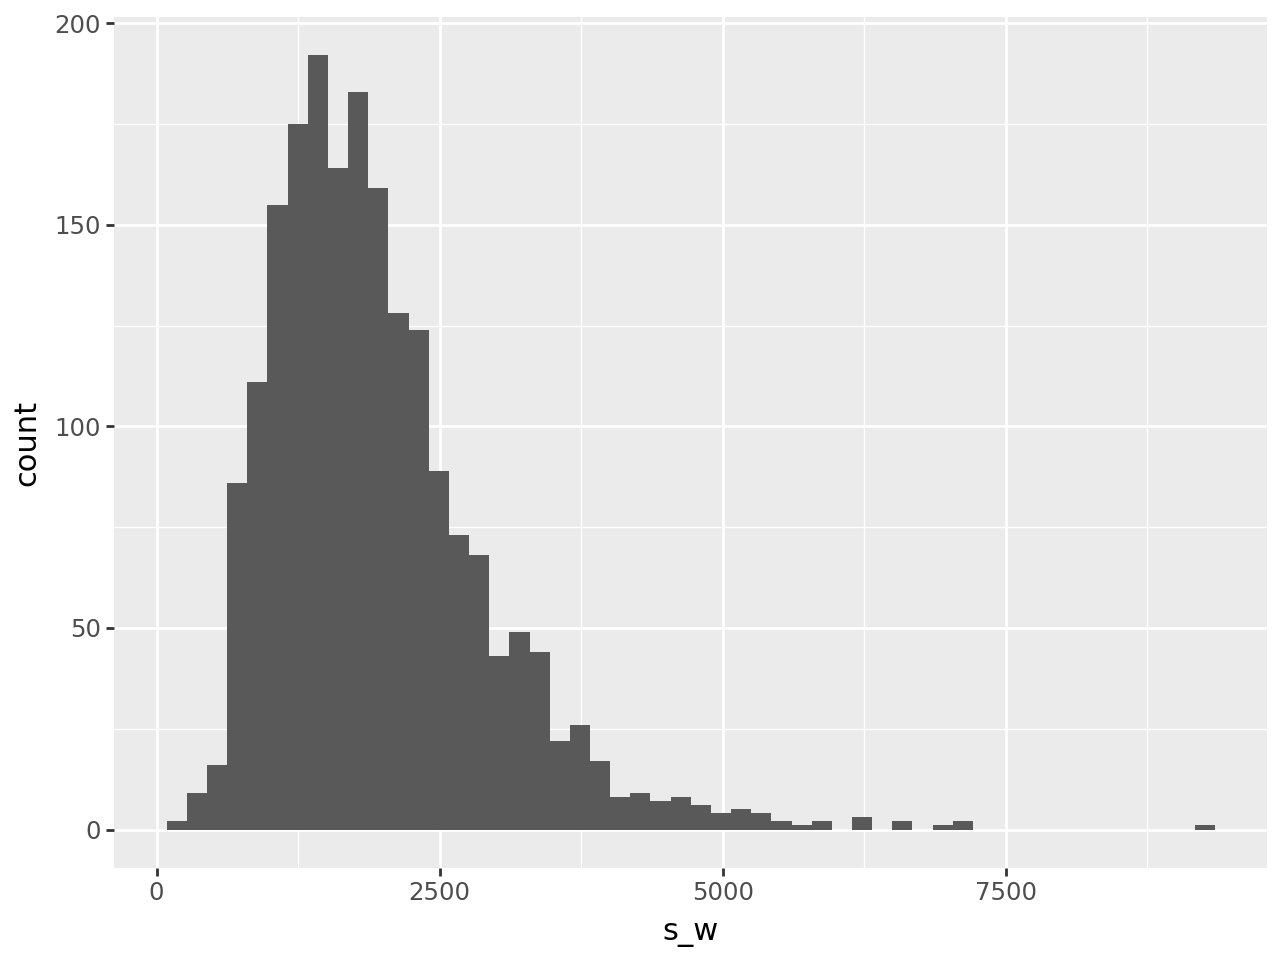

In [11]:
(
    ggplot()
    + geom_histogram(aes(x=result["s_w"]))
)

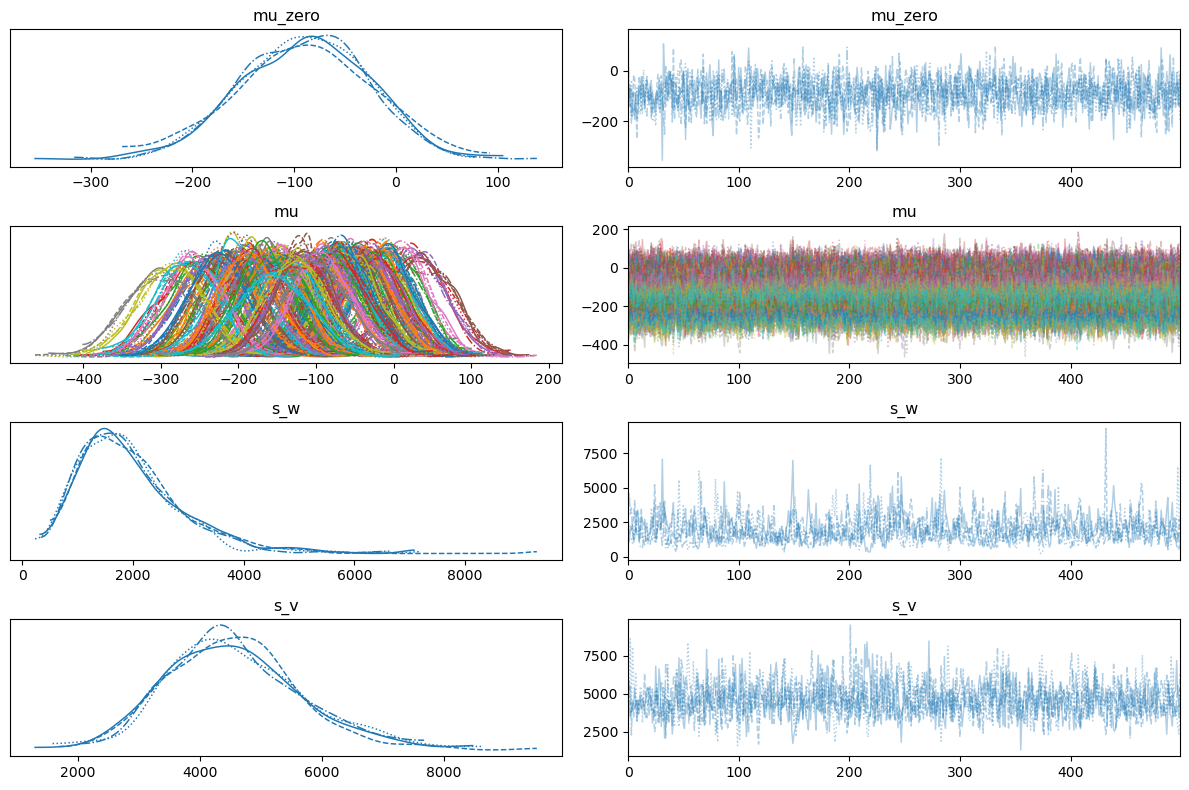

In [12]:
az.plot_trace(fit)
plt.tight_layout()